In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize, special
import pickle

Queremos estudiar cómo se comportan los viajes en domingo respecto a los viajes en sábado, para esto vamos a usar los datos del STC metro:

In [2]:
datametro = pd.read_csv("D:/Edgar Trejo/Universidad/BioMatematica/Modeling COVID-19 Spreading in the ZMVM/data/rawdata/afluenciastc_simple_02_2023.csv",
                       parse_dates = ['fecha'], encoding = 'latin')

La EOD fue hecha en el año 2017, se levantó entre el 23 de enero y el 3 de marzo. Vamos a usar los datos del metro registrados en esta ventana temporal.

In [6]:
datametroEOD = datametro[("2017-01-23" <= datametro['fecha']) & ( datametro['fecha'] <= "2017-03-03")].copy()

Queremos los datos de los días sábados y domingos. Obtenemos el día de la semana dada la fecha y filtramos para obtener dos tablas: una con datos de sábado y una con datos de domingo:

In [7]:
datametroEOD['wd'] = datametroEOD['fecha'].dt.day_name()

In [110]:
afluencia_sab = datametroEOD[datametroEOD.wd == 'Saturday']
afluencia_dom = datametroEOD[datametroEOD.wd == 'Sunday' ]

Agrupamos por fecha y estación para que esten ordenados.

In [112]:
afluencia_sab = afluencia_sab.groupby(['fecha', 'estacion'])['afluencia'].sum()
afluencia_dom = afluencia_dom.groupby(['fecha', 'estacion'])['afluencia'].sum()

El dato más 'viejo' es de `afluencia_sab` y el más antiguo es de `afluencia_dom` y además tienen la misma cantidad de datos por lo que ya no tenemos que recortar alguno.

Obtenemos las afluencias de cada tipo de día como un `array`.

In [113]:
sab = afluencia_sab.to_numpy()
dom = afluencia_dom.to_numpy()

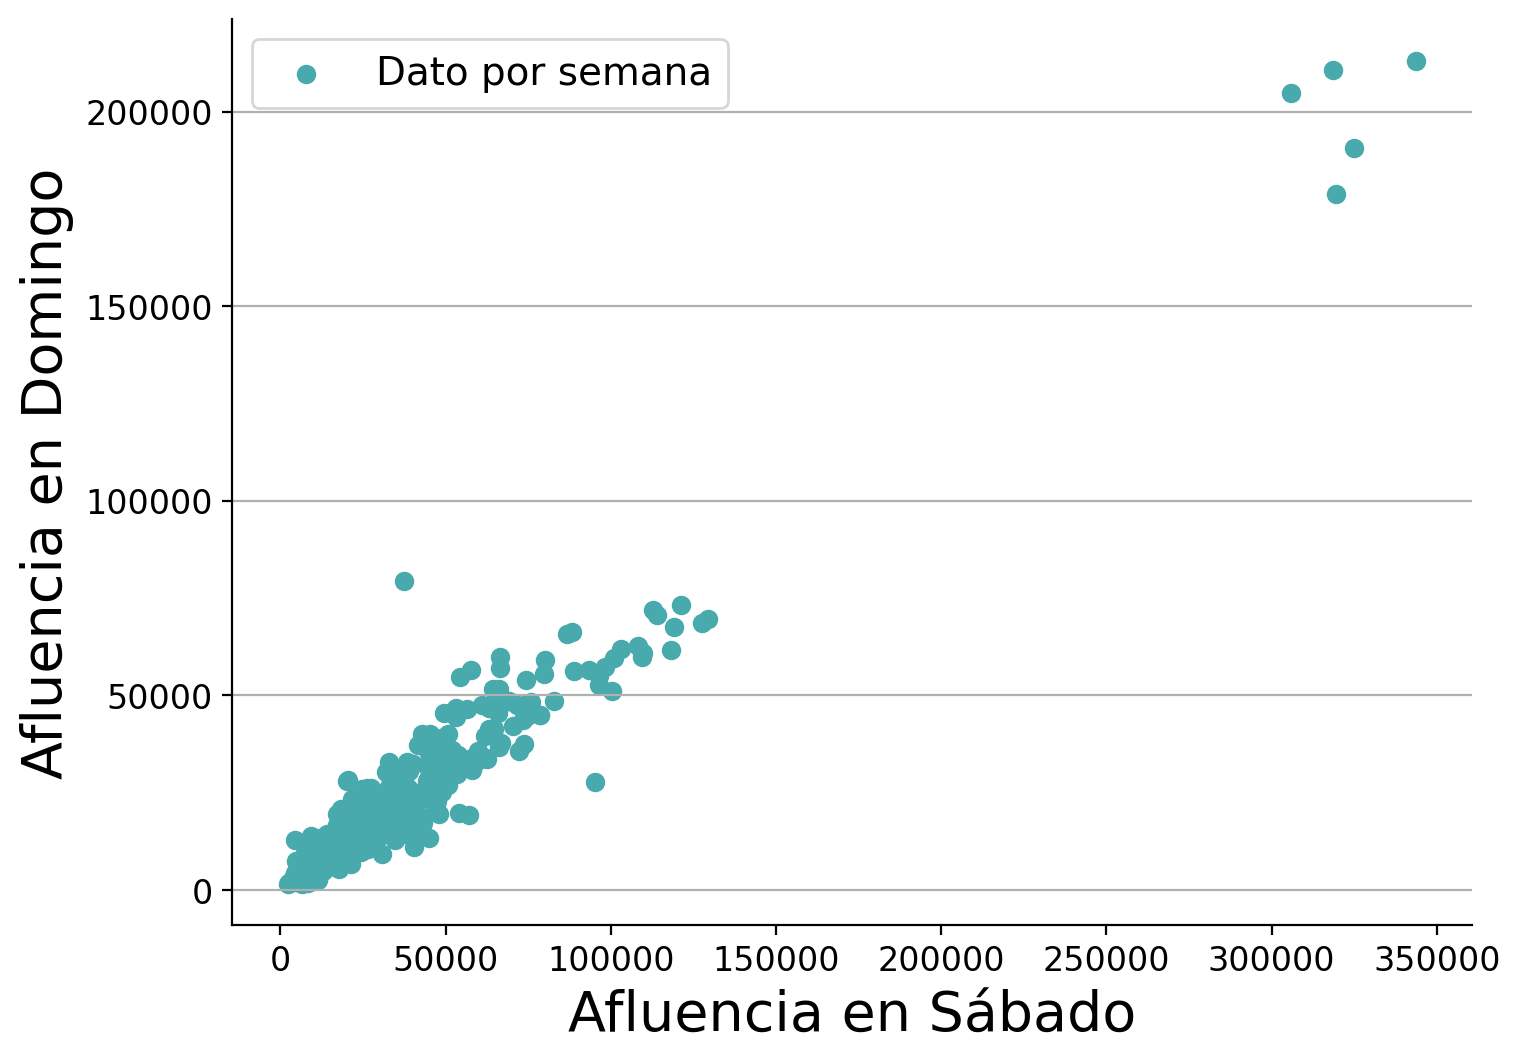

In [256]:
fig, ax = plt.subplots(figsize = (8, 6), dpi = 200)

ax.scatter(x = sab, y = dom, color = '#48aaad', label = 'Dato por semana')
ax.set_xlabel("Afluencia en Sábado", fontsize = 20)
ax.set_ylabel("Afluencia en Domingo", fontsize = 20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(prop = {'size':14})
plt.grid(axis = 'y')
plt.show()

In [213]:
ρ = stats.pearsonr(sab, dom)
ρ

(0.9699370557537081, 0.0)

Supongamos que el número de viajes en domingo es proporcional a los viajes en sábado y sean $S$ y $D$ variables aleatorias tales que $S$ es la afluencia en sábado y $D$ la afluencia de viajes en domingo. Sea $X=(S, D)$.

Definimos $\beta(X) = \frac{D}{S}$. 

In [175]:
β = dom/sab

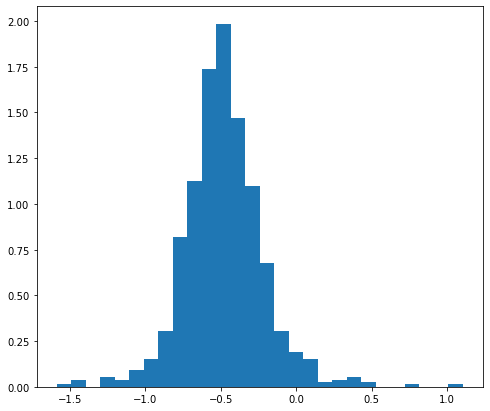

In [178]:
fig, ax = plt.subplots(figsize = (8, 7))

ax.hist(np.log(β), density = True, bins = int(np.sqrt(len(β))))

plt.show()

El logaritmo de $\beta$ parece una normal pero más angosta, tal vez una t-student. Vamos a ajustar los parámetros a los datos:

In [161]:
df, loc, scale = stats.t.fit(np.log(β))

In [164]:
df, loc, scale

(4.246351940961805, -0.4875913752999474, 0.19500024622788953)

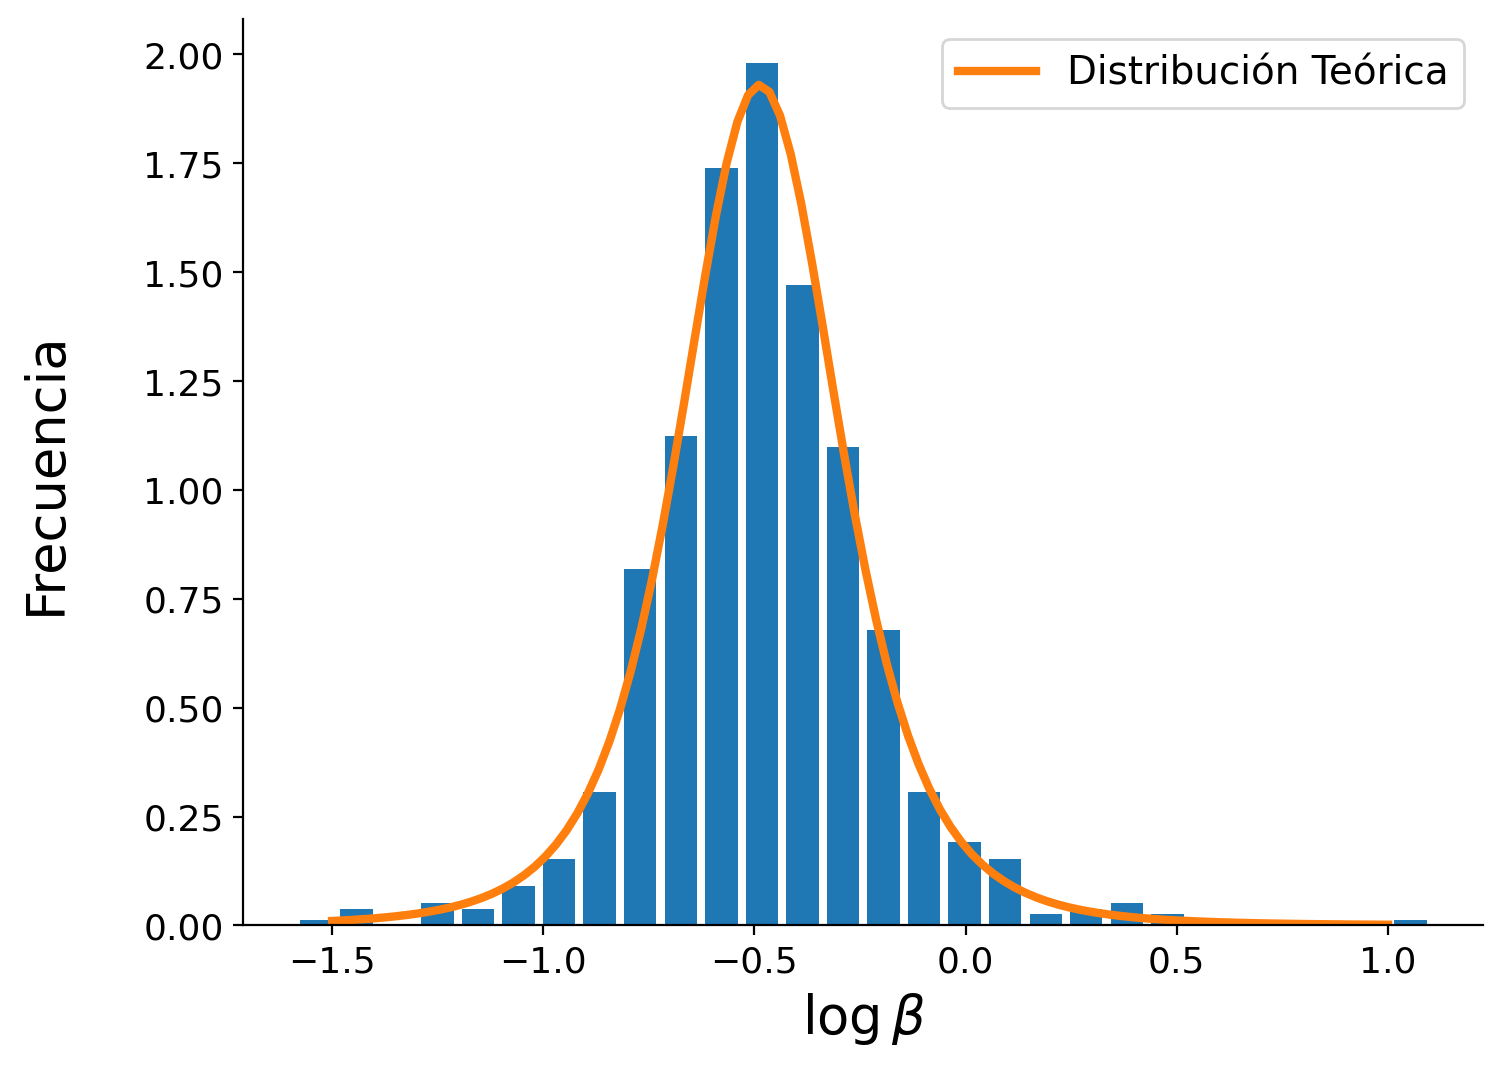

In [257]:
fig, ax = plt.subplots(figsize = (8, 6), dpi = 200)

t = np.linspace(-1.5, 1, 100)
ax.hist(np.log(β), density = True, bins = int(np.sqrt(len(β))), rwidth = 0.8)
ax.plot(t, stats.t.pdf(t, df, loc, scale), linewidth = 3, label = 'Distribución Teórica')

ax.spines[['right', 'top']].set_visible(False)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

ax.set_xlabel(r'$\log{\beta}$', fontsize = 19)
ax.set_ylabel('Frecuencia\n', fontsize = 19)
ax.legend(prop = {'size':14})
plt.show()

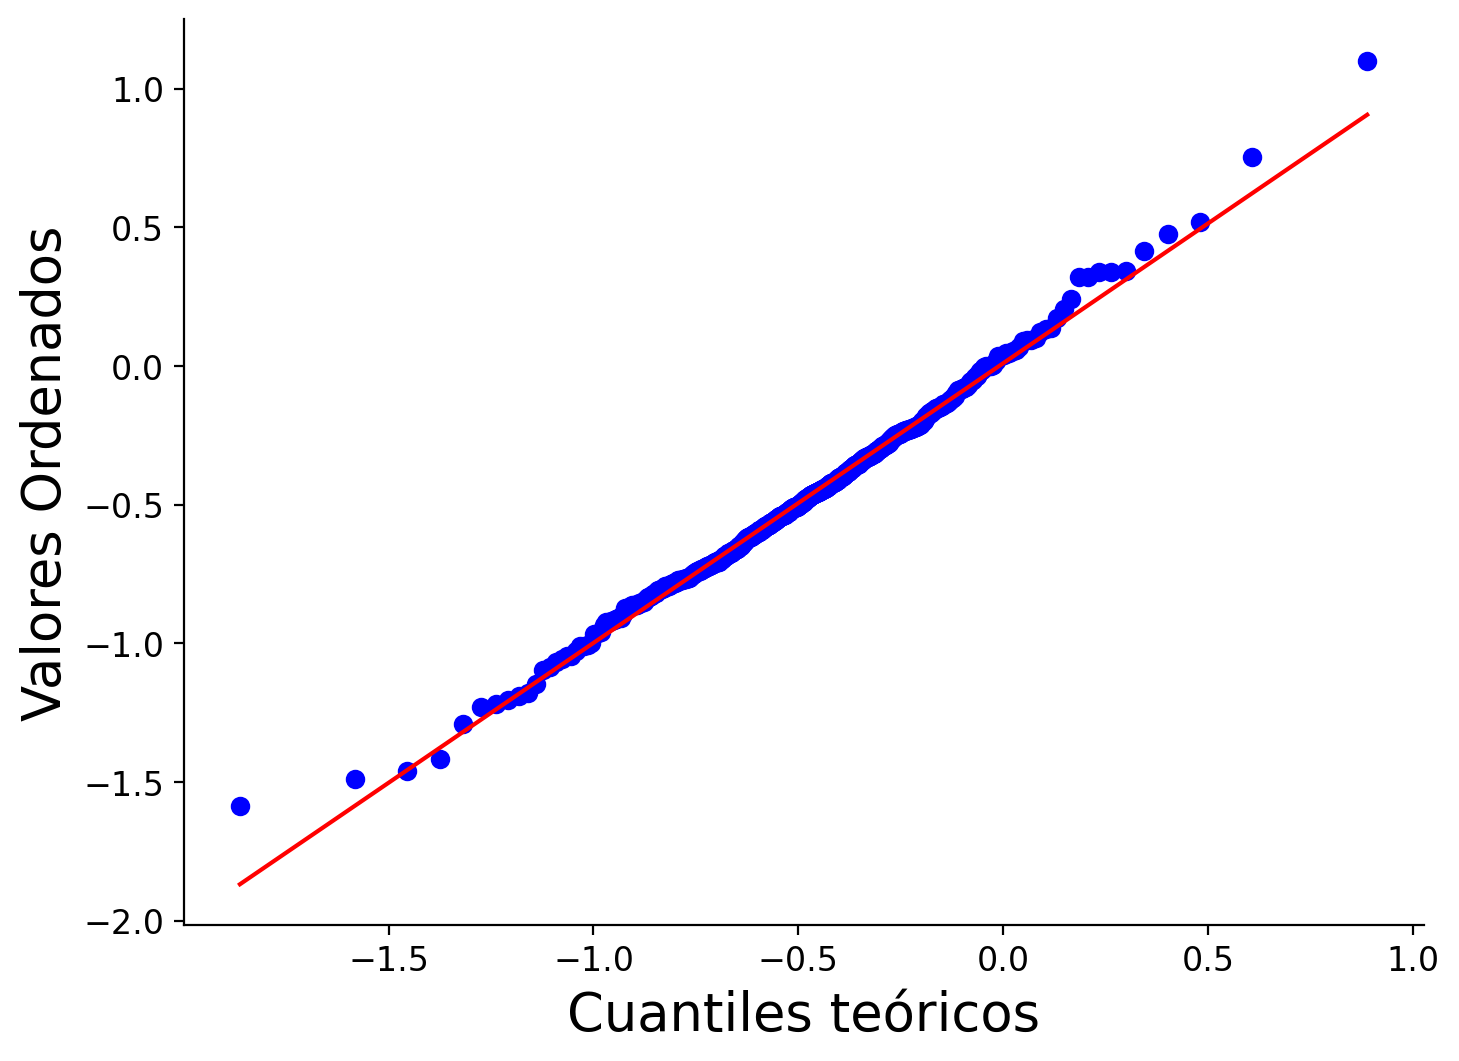

In [258]:
fig, ax = plt.subplots(figsize = (8, 6), dpi = 200)

stats.probplot(np.log(β), dist="t", sparams =(df, loc, scale), plot = ax)
ax.spines[['right', 'top']].set_visible(False)

ax.set_title('')
ax.set_ylabel('Valores Ordenados', fontsize = 19)
ax.set_xlabel('Cuantiles teóricos', fontsize = 19)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### Log-Normal se distribuye T-Student

In [162]:
stats.kstest(np.log(β), stats.t.cdf, args = (df, loc, scale) )

KstestResult(statistic=0.01757134194454274, pvalue=0.9590760607742581)

In [165]:
f_obs = stats.t.rvs(df, loc, scale, len(β))

In [167]:
stats.chisquare(np.log(β), f_obs, ddof = 3)

Power_divergenceResult(statistic=-540.1285288893627, pvalue=1.0)

Podemos suponer entonces que $\log \beta \sim \displaystyle\frac{t_{4.2463} + 0.4875}{0.195}$

In [211]:
with open("D:/Edgar Trejo/Universidad/BioMatematica/Modeling COVID-19 Spreading in the ZMVM/results/ajuste_sabdom.pkl", "wb") as handle:
    pickle.dump((df, loc, scale), handle)